# Cross-resonance gate between a transmon and a fluxonium: driving fluxonium

In this notebook we study the cross-resonance two-qubit gate between a transmon and a fluxonium. 

In [288]:
import time
from collections import defaultdict
from itertools import product, combinations
from typing import List, Dict, Callable, Optional
from pathlib import Path
import copy
import json
import cmath

import numpy as np
import xarray as xr
import scipy.integrate
import qutip as qtp
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from pysqkit import qubits, systems, couplers, drives, solvers, util
from util_cr import single_qubit_corrections, energy_levels_diagram

import pysqkit.util.transformations as trf
from pysqkit.drives.pulse_shapes import gaussian_top
from pysqkit.util.metrics import average_process_fidelity, average_gate_fidelity
from pysqkit.util.phys import temperature_to_thermalenergy
from pysqkit.util.quantum import generalized_rabi_frequency
from pysqkit.util.linalg import get_mat_elem
from pysqkit.util.hsbasis import weyl_by_index
from pysqkit.tomography import TomoEnv

from pysqkit.solvers.solvkit import integrate
from pysqkit.solvers import solvkit

from IPython.display import display, Latex

In [289]:
SOLVER_OPTIONS = qtp.solver.Options()
SOLVER_OPTIONS.atol = 1e-12
SOLVER_OPTIONS.rtol = 1e-10

The gate is based on the following driven Hamiltonian of a fluxonium and a transmon capacitively coupled

$$H = H^{(0)}_T + H^{(0)}_F + V + H_{drive},$$

$$H^{(0)}_T =  \hbar \omega_T \hat{b}^{\dagger}\hat{b} + \hbar \frac{\delta_T}{2} \hat{b}^{\dagger} \hat{b}^{\dagger}\hat{b} \hat{b},$$

$$H^{(0)}_F = 4 E_{C,F} \cdot \hat{q}^2_F + \frac{1}{2}E_{L,F}\cdot\hat{\varphi}^2_F - E_{J,F}\cos\left(\hat{\varphi}_F - \phi_{ext,F}\right),$$

$$V = J_C \cdot \hat{q}_T \cdot \hat{q}_F,$$

$$\frac{H_{drive}}{h} = \left( \varepsilon_T \hat{q}_T + \varepsilon_F \hat{q}_F \right) \cos(2\pi f_d t).$$

The (approximate) charge operator for the transmon in terms of annihilation and creation operators reads

$$
\hat{q}_T = i \biggl( \frac{E_J}{32 |\delta_T |} \biggr)^{1/4} (b^{\dagger} - b),
$$
where 
$$
E_J = \hbar \biggl(\frac{\omega_T - \delta_T}{8 | \delta_T |} \biggr)^2.
$$

In the following we introduce relaxation due to dielectric loss and pure dephasing on each qubit as error channels. 

The idea behind the cross-resonance gate is to drive one of the qubit at the frequency of the other using the fact that due to the coupling we have a $Z X$ term in the Hamiltonian. In particular, we will explore the idea of driving the fluxonium at the transmon frequency. The opposite idea to drive the transmon at the fluxonium frequency does not seem that promising. However, one might evaluate using Raman transitions.

# Define auxillary functions used

In [290]:
def comp_state_labels(num_qubits: Optional[int] = 2):
    state_combinations = product("01", repeat=num_qubits)
    labels = ["".join(states) for states in state_combinations]
    return labels

def state_labels(*qubit_states):
    state_combinations = product(*qubit_states)
    labels = ["".join(states) for states in state_combinations]
    return labels

def get_states(system, state_labels):
    states = {}
    for label in state_labels:
        _state = system.state(label)[1]
        
        loc = np.argmax(np.abs(_state))
        phase = cmath.phase(_state[loc])
        
        states[label] = np.exp(-1j*phase) * _state
    return states

In [291]:
def extract_freqs(
    qubit: systems.Qubit, 
) -> Dict[str, float]:
    """
    Description
    --------------------------------------------------------------
    Returns the transition frequencies of a given qubit.
    """
    
    num_levels = qubit.dim_hilbert
    
    results = {}
    
    states = [qubit.state(str(level)) for level in range(num_levels)]
        
    for level_i, level_j in combinations(range(num_levels), 2):
        freq_i = states[level_i][0]
        freq_j = states[level_j][0]
        results[f"freq_{level_i}{level_j}"] = freq_j - freq_i

    return results

In [292]:
def zz_crosstalk(system: systems.QubitSystem) -> float:
    xi_zz = system.state('00')[0] + system.state('11')[0] \
        - system.state('01')[0] - system.state('10')[0]
    return xi_zz

def xz_coeff(comp_states, op) -> float:
    xz0 = get_mat_elem(op, comp_states['00'], comp_states['10'])
    xz1 = get_mat_elem(op, comp_states['01'], comp_states['11'] )
    return (np.imag(xz0 - xz1))/2

def xi_coeff(comp_states, op) -> float:
    xi0 = get_mat_elem(op, comp_states['00'], comp_states['10'] )
    xi1 = get_mat_elem(op, comp_states['01'], comp_states['11'] )
    return (np.imag(xi0 + xi1))/2

In [293]:
def func_to_minimize(
    x: List[float],
    rise_time: float,
    amp: float
) -> float:
    pulse_time = x[0]
    time_step = 1e-3
    num_points = int(pulse_time/time_step)
    times = np.linspace(0, pulse_time, num_points)
    
    pulse = gaussian_top(times, rise_time, pulse_time)
    integral = scipy.integrate.simpson(2*np.pi*amp*pulse, times)
    return np.abs(integral - np.pi/4)  #Watch out factor of 2?  

In [294]:
def minimize_drive_time(
    system: systems.QubitSystem,
    comp_states: List[np.ndarray],
    eps_drive : float,
    rise_time : Optional[float] = 5.0,
    *,
    init_time : Optional[float] = 100.0,
) -> float:
    
    q_op = system["control"].charge_op()
    args_to_pass = (rise_time, np.abs(xz_coeff(comp_states, q_op))*0.5*eps_drive)

    try:
        minimization_result = minimize(
            func_to_minimize, 
            init_time,
            args=args_to_pass
        )
        gate_time = minimization_result['x'][0]
    except ValueError:
        gate_time = None
    
    return gate_time

def get_drive_params(
    system: systems.QubitSystem,
    comp_states: List[np.ndarray],
    eps_drive : float,
    rise_time : Optional[float] = 10.0,
    *,
    init_time : Optional[float] = 100.0,
    detuning : Optional[float] = 0,
    points_per_period : Optional[int] = 10
):
    pulse_time = minimize_drive_time(
        system = coupled_sys,
        comp_states = comp_states,
        eps_drive = eps_drive,
        rise_time = rise_time,
        init_time=init_time
    )
    
    if pulse_time is None:
        raise ValueError("Pulse time minimization has failed.") # Should be handled differently
    
    drive_freq = system["target"].freq
    
    num_points = int(pulse_time * drive_freq * points_per_period)
    times = np.linspace(0, pulse_time, num_points)

    params = dict(
        phase = 0, 
        time = times, 
        rise_time = rise_time, 
        pulse_time = pulse_time,
        amp = eps_drive, 
        freq = drive_freq + detuning
    )
    return params

In [295]:
def run_simulation(
    times: np.ndarray,
    system: systems.QubitSystem, 
    init_state: qtp.qobj.Qobj, 
    options: Optional[qtp.solver.Options] = None,
    *,
    solver="mesolve",
    with_noise: Optional[bool] = False
) -> qtp.solver.Result:
    sys_hamil = system.hamiltonian(as_qobj=True)
    drive_hamils = []
    drive_pulses = []
                    
    for qubit in system:
        if qubit.is_driven:
            for label, drive in qubit.drives.items():
                drive_hamils.append(drive.hamiltonian(as_qobj=True))
                drive_pulses.append(drive.eval_pulse())
    
    if with_noise:
        jump_ops = [op for qubit in system for op in qubit.collapse_ops(as_qobj=True)]
    else:
        jump_ops = []
                    
    result = integrate(
        times, 
        init_state, 
        sys_hamil, 
        drive_hamils,
        drive_pulses, 
        jump_ops, 
        solver=solver, 
        options=options
    )
                    
    return result  

In [296]:
def get_probabilities(
    state_labels : List[str], 
    system : systems.QubitSystem, 
    output_states : List[qtp.Qobj],
) -> Dict:
    probs_dict = {}
    
    for label in state_labels:
        probs = []
        
        state = system.state(label, as_qobj=True)[1]        
        projector = state*state.dag()
        
        for out_state in output_states:
            prob = qtp.expect(projector, out_state)
            probs.append(prob)
        
        probs_dict[label] = probs
    return probs_dict

In [297]:
def get_leakage(
    times: np.ndarray,
    system: systems.QubitSystem,
    comp_states: List[np.ndarray],
    options: Optional[qtp.solver.Options] = None,
    *,
    with_noise: Optional[bool] = False
):
    env_syst = TomoEnv(
        system=system, 
        time=2*np.pi*times, 
        options=options, 
        with_noise=with_noise
    )
    
    leakage = env_syst.leakage(comp_states)
    return leakage    

# Introducing the qubits and the coupled system

In [298]:
with open('../flx_transm_params.txt') as param_file:
    PARAM_SETS = json.load(param_file)
    
set_ind = "2"
PARAM_SET = PARAM_SETS[set_ind]

In [299]:
TEMPERATURE = 0.020
THERMAL_ENERGY = util.phys.temperature_to_thermalenergy(TEMPERATURE)

TRANSMON_LEVELS = 3
FLUXONIUM_LEVELS = 6

TRANSMON_ANHARM = -0.3 # Same as the parameter set
DIEL_LOSS_TANGENT = 3e-7

TARGET_FREQ = 5.300
SPEC_FREQ = 4.564473236189291

#Target transmon
target_transmon = qubits.SimpleTransmon(
    label = 'target', 
    max_freq = TARGET_FREQ, 
    anharm = TRANSMON_ANHARM,
    diel_loss_tan = PARAM_SET["dephasing_times_t"],
    env_thermal_energy = THERMAL_ENERGY,    
    dim_hilbert = TRANSMON_LEVELS
)

#Control fluxonium
control_fluxonium = qubits.Fluxonium(
    label = 'control', 
    charge_energy = PARAM_SET["charge_energy_f"], 
    induct_energy = PARAM_SET["induct_energy_f"], 
    joseph_energy = PARAM_SET["joseph_energy_f"], 
    diel_loss_tan = PARAM_SET["diel_loss_tan_f"],
    env_thermal_energy = THERMAL_ENERGY,
)
control_fluxonium.diagonalize_basis(FLUXONIUM_LEVELS)

# Spectator transmon
spec_transmon = qubits.SimpleTransmon(
    label = 'spectator', 
    max_freq = SPEC_FREQ, 
    anharm = TRANSMON_ANHARM,
    diel_loss_tan = DIEL_LOSS_TANGENT,
    env_thermal_energy = THERMAL_ENERGY,    
    dim_hilbert = TRANSMON_LEVELS
)

In [300]:
# We also add a drive on the fluxonium
control_fluxonium.add_drive(
    drives.microwave_drive,
    label = 'cr_drive',
    pulse = drives.pulses.cos_modulation,
    pulse_shape = drives.pulse_shapes.gaussian_top
)

In [301]:
coup_strength = PARAM_SET["jc"]

control_spectator_coup = couplers.capacitive_coupling(
    qubits=[control_fluxonium, spec_transmon],
    strength=coup_strength,
)

target_control_coup = couplers.capacitive_coupling(
    qubits=[target_transmon, control_fluxonium],
    strength=coup_strength,
)

In [302]:
bare_sys = target_transmon.couple_to(
    control_fluxonium,
)

coupled_sys = target_transmon.couple_to(
    control_fluxonium, 
    coupling = couplers.capacitive_coupling, 
    strength=coup_strength,
)

full_sys = systems.QubitSystem(
    qubits=[target_transmon, control_fluxonium, spec_transmon],
    coupling=[target_control_coup, control_spectator_coup]
)

In [303]:
print(f"Driven system qubit order: {[q.label for q in coupled_sys.qubits]}")
print(f"Full system qubit order: {[q.label for q in full_sys.qubits]}")

Driven system qubit order: ['target', 'control']
Full system qubit order: ['target', 'control', 'spectator']


In [326]:
fluxonium_freqs = extract_freqs(control_fluxonium)
assert fluxonium_freqs["freq_04"] - target_transmon.freq == SPEC_FREQ

In [307]:
comp_states = get_states(coupled_sys, comp_state_labels(2))

The basis principle behind the gate is illustrated in the following figure

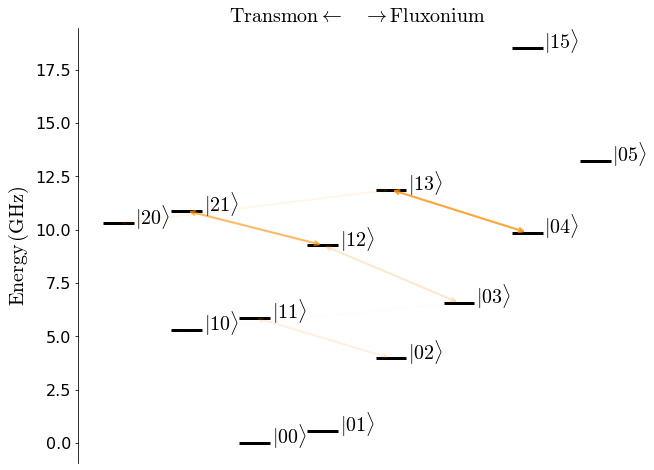

In [308]:
level_list = ['00', '01', '10', '11', '02', '20', '12','21', '03', '13', '04', '05', '15']
energy_levels_diagram(bare_sys, level_list, show_drive=False)

In [321]:
EPS_DRIVE = 0.62 #GHz
RISE_TIME = 10

drive_params = get_drive_params(
    system = coupled_sys,
    comp_states = comp_states,
    eps_drive = EPS_DRIVE,
    rise_time = RISE_TIME,
)
times =  drive_params["time"]
coupled_sys['control'].drives['cr_drive'].set_params(**drive_params)

In [322]:
_, init_state = coupled_sys.state('11', as_qobj=True)

output = run_simulation(
    times = 2*np.pi*times,
    system = coupled_sys,
    init_state = init_state, 
    options = SOLVER_OPTIONS,
)

In [323]:
labels = ['00', '10', '20', '03', '13', '01', '11', '04']
eval_step = 50

eval_times = times[::eval_step]
output_states = output.states[::eval_step]

eval_probs = get_probabilities(
   state_labels = labels, 
    system = coupled_sys, 
    output_states = output.states[::eval_step], 
)

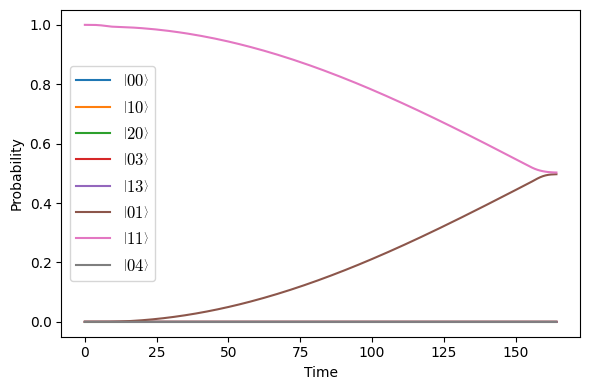

In [324]:
fig, ax = plt.subplots(dpi=100)

for ind, label in enumerate(labels):
    ax.plot(
        eval_times, 
        eval_probs[label], 
        label=f'$\\left|{label}\\right\\rangle$'
    )
    
plt.legend(fontsize=12)
ax.set_xlabel(r"Time")
ax.set_ylabel(r"Probability")
plt.tight_layout()

In [325]:
expected_leakage_rate = get_leakage(
    times = times,
    system = coupled_sys,
    comp_states = list(comp_states.values()),
    options = SOLVER_OPTIONS,
    with_noise = False
)
print(expected_leakage_rate)

3.7907838634776425e-07


# Probabilities involving spectator qubit

In [244]:
full_sys['control'].drives['cr_drive'].set_params(**drive_params)

In [245]:
_, init_state = full_sys.state('111', as_qobj=True)

output = run_simulation(
    times = 2*np.pi*times,
    system = full_sys,
    init_state = init_state, 
    options = SOLVER_OPTIONS,
)

In [246]:
labels = ["000", "001", "010", "011", "040", "041", "100", "101", "110", "111", "140", "141"]
eval_step = 50

eval_times = times[::eval_step]
output_states = output.states[::eval_step]

eval_probs = get_probabilities(
    state_labels = labels, 
    system = full_sys, 
    output_states = output.states[::eval_step], 
)

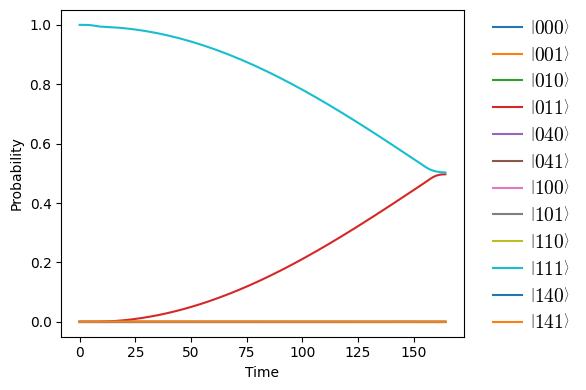

In [247]:
fig, ax = plt.subplots(dpi=100)

for ind, label in enumerate(labels):
    ax.plot(
        eval_times, 
        eval_probs[label], 
        label=f'$\\left|{label}\\right\\rangle$'
    )
    
plt.legend(
    frameon=False, 
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    handletextpad=0.4,
    labelspacing=0.4,
    markerscale=1.0,
    handlelength=1.5,
    borderaxespad=0.05,
    columnspacing=0.4,
    fontsize=14,
)
ax.set_xlabel(r"Time")
ax.set_ylabel(r"Probability")
plt.tight_layout()

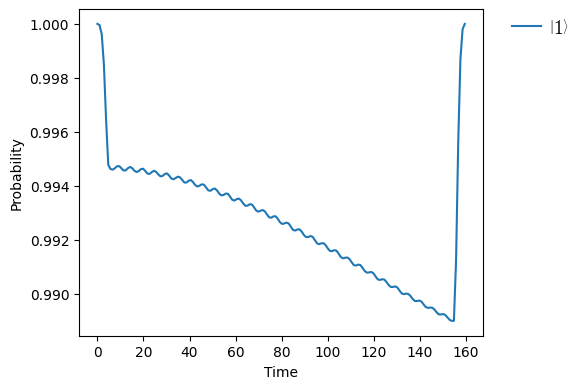

In [214]:
fig, ax = plt.subplots(dpi=100)

spec_state = "1"
spec_probs = np.zeros(len(eval_times), dtype=float)
for label in labels:
    if label[2] == spec_state:
        spec_probs += eval_probs[label]

ax.plot(
    eval_times, 
    spec_probs, 
    label=f'$\\left|{spec_state}\\right\\rangle$'
)
    
plt.legend(
    frameon=False, 
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    handletextpad=0.4,
    labelspacing=0.4,
    markerscale=1.0,
    handlelength=1.5,
    borderaxespad=0.05,
    columnspacing=0.4,
    fontsize=14,
)
ax.set_xlabel(r"Time")
ax.set_ylabel(r"Probability")
plt.tight_layout()

# Scans with the spectator transmon frequency

In [249]:
collision_cond

4.564473236189291

In [269]:
FREQ_RANGE = 0.1 # GHz
NUM_POINTS = 21

collision_cond = fluxonium_freqs["freq_04"] - target_transmon.freq
spectator_freqs = np.linspace(collision_cond - FREQ_RANGE, collision_cond + FREQ_RANGE, NUM_POINTS)

times = drive_params["time"]
leakage_rates = []

for spec_freq in spectator_freqs:
    spec_transmon = qubits.SimpleTransmon(
        label = 'spectator', 
        max_freq = spec_freq, 
        anharm = TRANSMON_ANHARM,
        diel_loss_tan = DIEL_LOSS_TANGENT,
        env_thermal_energy = THERMAL_ENERGY,    
        dim_hilbert = TRANSMON_LEVELS
    )
    
    control_spectator_coup = couplers.capacitive_coupling(
        qubits=[control_fluxonium, spec_transmon],
        strength=coup_strength,
    )
    
    full_sys = systems.QubitSystem(
        qubits=[target_transmon, control_fluxonium, spec_transmon],
        coupling=[target_control_coup, control_spectator_coup]
    )
    
    full_sys['control'].drives['cr_drive'].set_params(**drive_params)
    
    comp_states_dict = get_states(full_sys, comp_state_labels(3))
    comp_states = list(comp_states_dict.values())
    
    leakage_rate = get_leakage(
        times = times,
        system = full_sys,
        comp_states = comp_states,
        options = SOLVER_OPTIONS,
        with_noise = False
    )
    leakage_rates.append(leakage_rate)

In [277]:
leakage_arr = xr.DataArray(
    leakage_rates,
    dims = ["spectator_freq"],
    coords = dict(spectator_freq = spectator_freqs),
    attrs = dict(
        fluxonium_charge_energy = control_fluxonium.charge_energy,
        fluxonium_induct_energy = control_fluxonium.induct_energy,
        fluxonium_joseph_energy = control_fluxonium.joseph_energy,
        target_freq = target_transmon.freq,
        anharm = TRANSMON_ANHARM,
        collision_cond = collision_cond,
        pulse_time = drive_params["pulse_time"],
        rise_time = drive_params["rise_time"],
        drive_amp = drive_params["amp"], 
        drive_freq = drive_params["freq"],
        points_per_drive_period = 10
    )
)

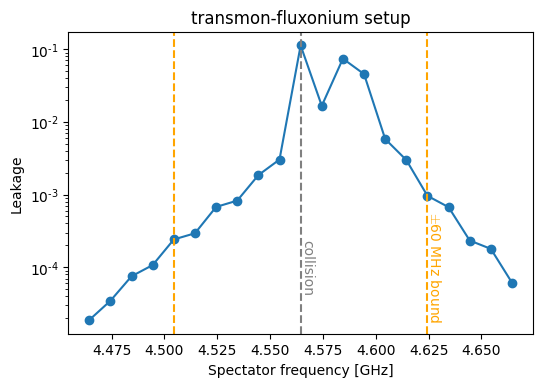

In [287]:
fig, ax = plt.subplots(dpi=100)

freq_range = 0.06

ax.plot(leakage_arr.spectator_freq, leakage_arr, linestyle="-", marker="o")
ax.axvline(leakage_arr.collision_cond, linestyle = "--", color="grey")

ax.text(leakage_arr.collision_cond, 1e-4, "collision", horizontalalignment="left", verticalalignment="center", rotation=-90, color="grey")

ax.axvline(leakage_arr.collision_cond - freq_range, linestyle = "--", color="orange")
ax.axvline(leakage_arr.collision_cond + freq_range, linestyle = "--", color="orange")

ax.text(collision_cond + freq_range, 1e-4, f"$\pm${int(freq_range*1e3)} MHz bound", horizontalalignment="left", verticalalignment="center", rotation=-90, color="orange")

ax.set_yscale("log")
ax.set_ylabel("Leakage")
ax.set_xlabel("Spectator frequency [GHz]")
ax.set_title("transmon-fluxonium setup")
plt.show()

In [398]:
SAVE_DATA = True

if SAVE_DATA:
    notebook_dir = Path.cwd()
    data_folder = notebook_dir / "data"
    data_folder.mkdir(parents=True, exist_ok=True)
    
    arr_name = f"mixed_device_spectator_two_photon_control_04_collision_scan.nc"
    leakage_arr.to_netcdf(data_folder / arr_name)

We introduce the TomoEnv object. We also refine the absolute and relative tolerance of the qutip solver 

In [271]:
simu_opt = qtp.solver.Options()
simu_opt.atol = 1e-12
simu_opt.rtol = 1e-10

env_syst = pysqkit.tomography.TomoEnv(system=coupled_sys, time=2*np.pi*tlist, options=simu_opt, with_noise=False)

The TomoEnv class can now return the superoperator representation of the quantum operation in an arbitrary Hilbert-Schmidt basis for a $d$-dimensional subspace, as long as this is a basis of diagonalizable operators. For instance the basis $|n \rangle \langle m|$, $n, m= 0, \dots, d-1$ is not a diagonalizable basis and thus the method cannot be used. 

In what follows we are interested in obtaining a superoperator representation of a quantum operation in the computational subspace that we here define

In [272]:
comp_states_list = []
for key in comp_states.keys():
    comp_states_list.append(comp_states[key])

We remark that the specification of the subspace is left to the user and it has arbitrary dimension. The user must check that the given kets are indeed orthogonal. 

In what follows we will use the Weyl basis for qudits ($d>2$) as Hilbert-Schmidt basis. These are defined via the standard definition of $Z$ and $X$ operators for qudits (see Howard et al Nature volume 510, pages351–355 (2014)):

$$
Z | j \rangle= \omega^j | j \rangle,
$$
$$
X | j \rangle = | j + 1 \mod d \rangle,
$$
where $\omega = \exp \bigl[ \frac{2 \pi i}{d} \bigr ]$.

The (normalized) Weyl operators for qudits are defined as

$$
D(\boldsymbol{\xi})=D \bigl( \boldsymbol{\xi} = \begin{bmatrix}\xi_x & \xi_z 
\end{bmatrix}^T \bigr) = \frac{1}{\sqrt{d}} \omega^{- \frac{d+1}{2} \xi_x \xi_z} X^{\xi_x} Z^{\xi_z}, \quad \xi_x, \xi_z \in \mathbb{Z}_d = \{0, 1, \dots, d-1 \}.
$$
The Weyl operators form an orthonormal basis for the Hilbert space of (bounded) $d \times d$ matrices with Hilbert-Schmidt inner product

$$
\langle A, B \rangle = \mathrm{Tr}(A^{\dagger} B).
$$
In fact
$$
\langle D(\boldsymbol{\xi}), D(\boldsymbol{\xi}') \rangle = \delta_{\boldsymbol{\xi}, \boldsymbol{\xi}'}.
 $$

In order to use this basis to write our superoperator we simply need a function that orders them. Thus, this function should take as argument an index $i$ associated with the Weyl operator as well as the qudit dimension $d$ ($i < d^2$). The same is valid for any orthonormal Hilbert-Schmidt basis we wish to define, as long as it is a basis of diagonalizable matrices. 


We can easily obtain the superoperator in the Weyl basis. Notice that this gives information only within the defined computational subspace and not on the leakage subspace. Thus the following superoperator is complete knowledge of the states within the computational subspaces only if the leakage is zero. However, the following superoperator is the one needed to compute process fidelities as described in Eq. 8 of Wood-Gambetta Phys. Rev. A 97, 032306 (2018). The method to_super in the TomoEnv class is parallelized and we can specify the number of processes. 

In [273]:
n_process = 4

start = time.time()
sup_op = env_syst.to_super(comp_states_list, weyl_by_index, n_process)
end = time.time()
print("Computational time = " + str(end - start) + ' s')

Computational time = 170.13243341445923 s


Notice how the superoperator can be obtained for any system and its operations are completely system agnostic.

We now use the previous superoperator to compute the process fidelity and average gate fidelity with respect to a $\mathrm{CZ}$ gate. First of all, we need to obtain the single-qubit gate corrections. This can be done directly from the superoperator via the following function.

In [274]:
sq_corr = util.single_qubit_corrections(sup_op, weyl_by_index)
sq_corr_sup = trf.kraus_to_super(sq_corr, weyl_by_index)
total_sup_op = sq_corr_sup.dot(sup_op)

We now compute the process fidelity. In order to do this we first need to obtain the superoperator representation of the $\mathrm{CZ}$ in the Weyl basis. This can be done via the function qutip.util.transformations.kraus_to_super

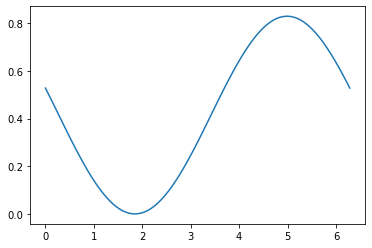

In [275]:
def cry(theta):
    ide = np.identity(4)
    yz = np.kron(np.array([[0, -1j], [1j, 0]]), np.array([[1, 0], [0, -1]]))
    return np.cos(theta/2)*ide - 1j*np.sin(theta/2)*yz

def crx(theta):
    ide = np.identity(4)
    zx = np.kron(np.array([[0, 1], [1, 0]]), np.array([[1, 0], [0, -1]]))
    return np.cos(theta/2)*ide - 1j*np.sin(theta/2)*zx

theta_list = list(np.linspace(0, 2*np.pi, 100))
fid_list = []
for theta in theta_list:
    cr_super = trf.kraus_to_super(cry(theta), weyl_by_index)
    fid_list.append(average_process_fidelity(cr_super, total_sup_op))

plt.plot(theta_list, fid_list)
plt.show()

We can now compute the process fidelity

In [276]:
cr_super_target = trf.kraus_to_super(cry(-np.pi/2), weyl_by_index)
f_pro = average_process_fidelity(cr_super_target, total_sup_op)
display(Latex(r'$F_{{pro}} = {:.5f}$'.format(f_pro)))

<IPython.core.display.Latex object>

Notice that this is by choice not done within the TomoEnv class, since the TomoEnv class should be agnostic of which gate we want to implement. Since during the gate also an unwanted $Y$ rotations is implemented let us try to virtually correct it. In particular, we look for the $Y$ rotation on the transmon that maximized the fidelity.

In [277]:
def ry_t(theta):
    rot_y = np.cos(theta/2)*np.identity(2) - 1j*np.sin(theta/2)*np.array([[0, -1j], [1j, 0]])
    return np.kron(rot_y, np.identity(2))

def ry_f(theta):
    rot_y = np.cos(theta/2)*np.identity(2) - 1j*np.sin(theta/2)*np.array([[0, -1j], [1j, 0]])
    return np.kron(np.identity(2), rot_y)

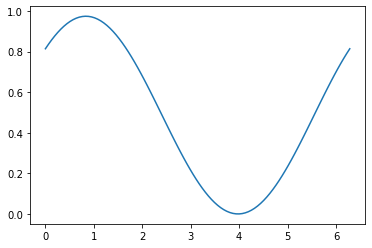

<IPython.core.display.Latex object>

In [278]:
fid_list_ry = []
for theta in theta_list:
    rot_y_super = trf.kraus_to_super(ry_t(theta), weyl_by_index)
    fid_list_ry.append(average_process_fidelity(cr_super_target, rot_y_super.dot(total_sup_op)))

fid_ry = np.array(fid_list_ry)

plt.plot(theta_list, fid_ry)
plt.show()
max_fid = np.max(fid_ry)
max_index = np.argmax(fid_ry)
sup_rot_y_opt = trf.kraus_to_super(ry_t(theta_list[max_index]), weyl_by_index)
display(Latex(r"Maximum achievable fidelity after ideal $Y$ rotations = ${}$".format(max_fid)))

The average leakage and seepage is instead computed within the TomoEnv class. This is because we just need to specify a subspace to determine them, similarly to the determination of the superoperator. We use Eq. 2 and 3 in Wood-Gambetta Phys. Rev. A 97, 032306 (2018) to calculate the average leakage and seepage respectively. 

In [80]:
avg_leakage = env_syst.leakage(comp_states_list)
display(Latex(r'$L_1(\mathcal{{E}} ) = {:.7f}$'.format(avg_leakage)))

<IPython.core.display.Latex object>

We observe that leakage is sensitive to whether we have a smooth rise time or not...

In [23]:
avg_seepage = env_syst.seepage(comp_states_list)
display(Latex(r'$L_2(\mathcal{{E}} ) = {:.7f}$'.format(avg_seepage)))

<IPython.core.display.Latex object>

We can also check that with the selected accuracy of the qutip solver, for unitary dynamics (set loss tangents equal to zero) we reproduce the relation between leakage and seepage $d_1 L_1(\mathcal{E}) = d_2 L_2(\mathcal{E})$ ($d_1=4, d_2 = 11$)

In [335]:
display(Latex(r'$d_1 L_1(\mathcal{{E}} ) = {:.7f}$'.format(d_comp*avg_leakage)))

<IPython.core.display.Latex object>

In [336]:
display(Latex(r'$d_2 L_2(\mathcal{{E}} ) = {:.7f}$'.format(d_leak*avg_seepage)))

<IPython.core.display.Latex object>

Finally, the average gate fidelity is

In [27]:
total_sup_op_ry = sup_rot_y_opt.dot(total_sup_op)
f_gate = average_gate_fidelity(cr_super_target, total_sup_op_ry, avg_leakage)
display(Latex(r'$F_{{gate}} = {:.5f}$'.format(f_gate)))


<IPython.core.display.Latex object>

It is clear that the main source of error is leakage. Let us thus check where the leakage is coming from mainly.

# Leakage analysis

To study leakage we consider the noiseless case

In [54]:
def run(
    time: np.ndarray,
    system: QubitSystem, 
    state_init: qtp.qobj.Qobj, 
    options: qtp.solver.Options=None
):
    hamil0 = system.hamiltonian(as_qobj=True)
    hamil_drive = []
    pulse_drive = []
                    
    for qubit in system:
        if qubit.is_driven:
            for label, drive in qubit.drives.items():
                hamil_drive.append(drive.hamiltonian(as_qobj=True))
                pulse_drive.append(drive.eval_pulse())
    jump_op = [op for qubit in system for op in qubit.collapse_ops(as_qobj=True)]
                    
    result = integrate(time, state_init, hamil0, hamil_drive,
                           pulse_drive, jump_op, "mesolve", options=options)
                    
    return result  

In [55]:
start = time.time()

_proj_comp = np.einsum('ai, aj -> ij', comp_states_list, np.conj(comp_states_list))
subsys_dims = list(q.dim_hilbert for q in coupled_sys)
proj_comp = qtp.Qobj(inpt=_proj_comp, dims=[subsys_dims, subsys_dims], isherm=True)
res = run(time=2*np.pi*tlist, system=coupled_sys, state_init=proj_comp/d_comp, options=simu_opt)

end=time.time()
display(Latex(r'$\mathrm{{Leakage \, computation \, time}} = {:.3f} \, s$'.format(end - start)))
l1 = 1 - qtp.expect(proj_comp, res.states[-1])

<IPython.core.display.Latex object>

In [56]:
comp_state_label = ['00', '01', '10', '11']
leakage_states = []
for lev_t in range(0, levels_t):
    for lev_f in range(0, levels_f):
        if str(lev_t) + str(lev_f) not in comp_state_label:
            leakage_states.append(str(lev_t) + str(lev_f))

In [57]:
def get_probabilities(
    states_label: List[str], 
    system:QubitSystem, 
    final_state: qtp.qobj.Qobj
) -> Dict:
    prob = {}
    for label in states_label:
        ket = system.state(label, as_qobj=True)[1]
        projector = ket*ket.dag()
        prob[label] = qtp.expect(projector, final_state)
    return prob

In [58]:
leak_probs = get_probabilities(leakage_states, coupled_sys, res.states[-1])

display(Latex(r'$\mathrm{{Average\, Leakage \,}} L_1 = {:.7f} $'.format(l1)))

sum_leak = 0

for label in leakage_states:
    display(Latex(r'$P_{{leak, {}  }} = {:.7f}$'.format(label, leak_probs[label])))
    sum_leak += leak_probs[label]
display(Latex(r'$\sum_k P_{{leak, k  }} = {:.7f}$'.format(sum_leak)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

We notice that leakage is quite heterogeneous in the sense that many levels are a bit populated. I think this problem can be solved by several strategies such as optimizing the coupling, increasing the gate time or by taking larger frequency differences between the transmon and the higher levels of the fluxonium. Indeed, by reducing the coupling, at the price of a doubled gate time for fixed drive strength, we have much less leakage.

In [327]:
4.950 - 0.110

4.84

In [328]:
330

330

In [334]:
0.5*(5.21 + 5.140 + 0.330)

5.34

In [336]:
(2*5.21 -0.330 - 5.14)

4.95

5.28

In [342]:
a = - 0.33
f_control_01 = 5.210
f_control_12 = f_control_01 + a
f_control_02= 2*f_control_01 + a

f_target_01 = 5.140
f_target_12 = f_target_01 + a
f_target_02 = 2*f_target_01 + a


In [343]:
f_control_02 - f_target_01

4.95

In [345]:
f_control_02 - f_target_12

5.28

In [353]:
f_control_02 - f_target_01

4.95

In [360]:
f_target_01 - (a/2)

5.305

In [365]:
f_target_02 - f_control_01

4.739999999999999

In [369]:
f_target_12

4.81

In [370]:
f_control_12

4.88

In [377]:
f_target_01 - f_control_12

0.2599999999999998

In [380]:
5.34

5.34

In [381]:
5.34  - 0.33

5.01

In [382]:
2*5.34  - 0.33

10.35

In [384]:
2*f_target_01

10.28

In [397]:
0.5*(f_target_01 + f_control_01 - a)

5.34